<a href="https://colab.research.google.com/github/MohamadMahdiDarvishi/Tensorflow/blob/main/Notebooks/Tensorflow_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 1 : Food Vision Big 🍔

## 0. Prerequirities

In [ ]:
# Imports
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

❗ **Note**

There is diffrent gpus for deep learning but there is just few of them used for mixed precision including `tesla T4` which is presented by google colab

In [ ]:
# GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-7cc13ef7-13a9-a48e-fa79-f907b42fa66a)


In [ ]:
# Download helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
# Import functions
from helper_functions import plot_loss_curves , compare_historys , create_tensorboard_callback

--2023-09-08 14:15:47--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-09-08 14:15:47 (126 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Prepare data

### Using `TensorFlow Datasets` (TFDS) to download datasest

In [ ]:
import tensorflow_datasets as tfds

In [ ]:
list_datasets = tfds.list_builders()
"food101" in list_datasets

True

In [ ]:
(train_data , test_data) , ds_info = tfds.load(name  = "food101" ,
                                               as_supervised = True ,
                                               split = ["train" , "validation"] ,
                                               shuffle_files = True ,
                                               with_info = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete4SNQO0/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete4SNQO0/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


### A glance at our data

In [ ]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [ ]:
class_names = ds_info.features["label"].names
len(class_names) , class_names[-10:]

(101,
 ['spaghetti_carbonara',
  'spring_rolls',
  'steak',
  'strawberry_shortcake',
  'sushi',
  'tacos',
  'takoyaki',
  'tiramisu',
  'tuna_tartare',
  'waffles'])

In [ ]:
image , label = list(train_data.take(1))[0][0] , list(train_data.take(1))[0][1]
print(f"""
image shape : {image.shape}
image_datatype : {image.dtype}
image label : {label.numpy()}
food class : {class_names[label.numpy()]}
""")


image shape : (512, 512, 3)
image_datatype : <dtype: 'uint8'>
image label : 45
food class : frozen_yogurt



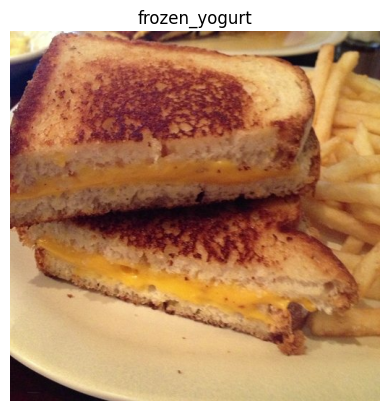

In [ ]:
# plot an image from datasest
plt.imshow(image) ;
plt.title(class_names[label.numpy()]) ;
plt.axis("off") ;

### Operating Preprocessing on data

models prefer to look at data in special terms including rescaled (0 & 1) , reshaped (224,224) , and with float data type (tf.float)

❗ **Note**

in this notebook we are using `efficientB0` which prefers to look at data in for of not scaled

but in other terms its like other models and prefer :

* float data type
* a specific target size

in order we are going to map our preprocessing function to our dataset and make sure they are parallel

In [ ]:
def preprocessing_img(img , label , img_shape=224) :
  """
  Summary :
    1. Converts image datatype from 'uint8' -> 'float32' and reshapes
    2. image to [img_shape, img_shape, colour_channels]

  Hint :
    as we are using EfficientB0 base_model we don't need resaclling

  Args :
    img (np.array) : image in format (224,224,3)
    label (int) : label of image in integer format

  Returns :
    returning the resized image with float data type

  """
  # 1. resizing images
  img = tf.image.resize(img , [img_shape , img_shape])
  # converting image data types and returning them
  return tf.cast(img , tf.float32) , label

In [ ]:
# presprocess an image
preprocessing_image , preprocessing_label = preprocessing_img(img = image ,
                                                label = label ,
                                                img_shape = 224)

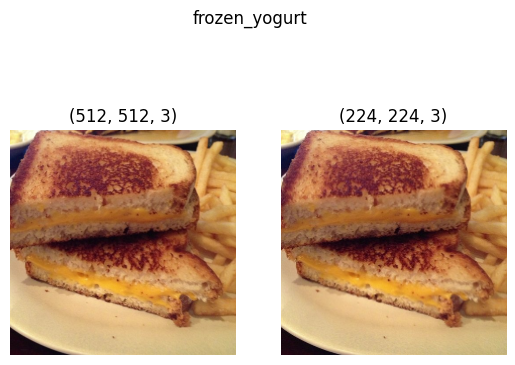

In [ ]:
# visualize a prrprocessed image
plt.suptitle(class_names[preprocessing_label]) ;
plt.subplot(1,2,1) ;
plt.imshow(image) ;
plt.title(image.shape) ;
plt.axis("off") ;
plt.subplot(1,2,2) ;
plt.imshow(preprocessing_image/255.0) ;
plt.title(preprocessing_image.shape) ;
plt.axis("off") ;

### Batch and Prepare datasest

In [ ]:
# mapping preprocessing function and making sure that our data are parallel
train_data = train_data.map(map_func = preprocessing_img , num_parallel_calls = tf.data.AUTOTUNE)
# shuffling our data and making batches and prefetching data for faster processing
train_data = train_data.shuffle(buffer_size = 1000).batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)
# same process for test data insted of shuffling
test_data = test_data.map(map_func = preprocessing_img , num_parallel_calls = tf.data.AUTOTUNE).batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
train_data , test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

### making callbacks

In [ ]:
# making the place to save checkpoints
checkpoint_path = "model_checkpoints/cp.ckpt"
# making checkpoint callback function
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path ,
                                                               verbose = 0 ,
                                                               save_best_only = True ,
                                                               save_weights_only = True ,
                                                               monitor = "val_acc")

## setup mixed precision training

mixed precision training actully means to train model on data with different data type and actully we must set a setting for that including :

`tf.keras.mixed_precision.set_global_policy()`

In [ ]:
# turnon mixed precision training
tf.keras.mixed_precision.set_global_policy("mixed_float16")

In [ ]:
# checking mixed precision global policy
tf.keras.mixed_precision.global_policy()

<Policy "mixed_float16">

## Build Feature Extraction model

In [ ]:
# building base model
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# Create layers
inputs = tf.keras.Input(shape = (224 ,224 ,3) , name = "input_layer")
x = base_model(inputs , training = False)
x = tf.keras.layers.GlobalAveragePooling2D(name  = "global_average_pooling_2d_layer")(x)
outputs = tf.keras.layers.Dense(len(class_names) , name  = "output_layer" , activation = tf.keras.activations.softmax)(x)

# mading up model
model = tf.keras.Model(inputs , outputs)

# compile_model
model.compile(loss = tf.keras.losses.sparse_categorical_crossentropy ,
              optimizer = tf.keras.optimizers.Adam() ,
              metrics = ["accuracy"])

# fit model
results = model.fit(epochs = 3 ,
                    x = train_data ,
                    validation_data = test_data ,
                    steps_per_epoch = len(train_data) ,
                    validation_steps = len(test_data) ,
                    callbacks = [create_tensorboard_callback(
                        dir_name = "tensorboard" ,
                        experiment_name = "mixed_precision_feature_extraction") ,
                                 model_checkpoint_callback])

Saving TensorBoard log files to: tensorboard/mixed_precision_feature_extraction/20230908-145123
Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.7194 - accuracy: 0.5814

2368/2368 [==============================] - 242s 97ms/step - loss: 1.7194 - accuracy: 0.5814 - val_loss: 1.1372 - val_accuracy: 0.6984
Epoch 2/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.1993 - accuracy: 0.6897

2368/2368 [==============================] - 229s 95ms/step - loss: 1.1993 - accuracy: 0.6897 - val_loss: 1.0370 - val_accuracy: 0.7219
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 1.0537 - accuracy: 0.7228

2368/2368 [==============================] - 260s 108ms/step - loss: 1.0537 - accuracy: 0.7228 - val_loss: 1.0048 - val_accuracy: 0.7262


### A Glance at model

In [ ]:
for i , layer in enumerate(base_model.layers) :
  print(i , layer.name , layer.trainable , layer.dtype , layer.dtype_policy)

0 input_5 False float32 <Policy "float32">
1 rescaling_8 False float32 <Policy "mixed_float16">
2 normalization_4 False float32 <Policy "mixed_float16">
3 rescaling_9 False float32 <Policy "mixed_float16">
4 stem_conv_pad False float32 <Policy "mixed_float16">
5 stem_conv False float32 <Policy "mixed_float16">
6 stem_bn False float32 <Policy "mixed_float16">
7 stem_activation False float32 <Policy "mixed_float16">
8 block1a_dwconv False float32 <Policy "mixed_float16">
9 block1a_bn False float32 <Policy "mixed_float16">
10 block1a_activation False float32 <Policy "mixed_float16">
11 block1a_se_squeeze False float32 <Policy "mixed_float16">
12 block1a_se_reshape False float32 <Policy "mixed_float16">
13 block1a_se_reduce False float32 <Policy "mixed_float16">
14 block1a_se_expand False float32 <Policy "mixed_float16">
15 block1a_se_excite False float32 <Policy "mixed_float16">
16 block1a_project_conv False float32 <Policy "mixed_float16">
17 block1a_project_bn False float32 <Policy "mix